In [1]:
# Libraries
import numpy as np
import pandas as pd
import gym
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
import seaborn as sns

# Pandas configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set_context("talk")

C:\Users\carlo\.conda\envs\RL\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


# Monte Carlo ES (Exploring Starts)
The environment is deterministic (it never changes). Exploring starts with Monte Carlo.

In [3]:
# Action to take at state S.
policy = {}

# Returns
monte_carlo = pd.DataFrame(columns=["state", "action", "return"])
gamma = 0.99

# Environment
env = gym.make("FrozenLake-v1")

# Iteration Period
for _ in tqdm(range(10000)):

    # Set up environment
    env.reset()

    # Select a random start S0, A0.
    state, action = env.observation_space.sample(), env.action_space.sample()

    # Change initial state
    env = env.unwrapped
    env.s = state
    #env.render()

    done = False

    # Cache
    episode_states = [state]
    episode_actions = [action]
    episode_rewards = []

    while not done:
   
        new_state, reward, done, _ = env.step(action)
        #env.render()

        # Random if needed
        if new_state not in policy:
            policy[new_state] = env.action_space.sample()

        new_action = policy[new_state]
        
        # Append new values
        episode_states.append(new_state)
        episode_actions.append(new_action)
        episode_rewards.append(reward)

        # Update values
        state, action = new_state, new_action

    # G
    G = 0
    
    for idx in range(len(episode_rewards)):

        G = gamma*G + episode_rewards[-(idx+1)]

        if (episode_states[-(idx+2)], episode_actions[-(idx+2)]) not in zip(episode_states[:-(idx+2)],episode_actions[:-(idx+2)]):

            new = pd.DataFrame([[episode_states[-(idx+2)], episode_actions[-(idx+2)], G]], columns=["state", "action", "return"])
            monte_carlo = pd.concat([monte_carlo, new])

            # Calculate average returns
            average_returns = monte_carlo.groupby(["state","action"])["return"].mean().reset_index()

            # Update Policy
            new_policy = average_returns.copy()
            new_policy["rn"] = average_returns.sort_values(["state","return"], ascending=[True,False]).groupby(['state']).cumcount() + 1
            new_policy = new_policy[new_policy["rn"]==1]

            for _, row in new_policy.iterrows():
                policy[int(row['state'])] = int(row['action'])


100%|██████████| 10000/10000 [06:10<00:00, 26.96it/s]


## Policy

In [11]:
env_h = 4
env_w = 4

direction_dict = {0:"←", 1:"↓", 2:"→", 3:"↑"}
new_policy["label"] = new_policy["action"].apply(lambda x: direction_dict[x])
new_policy["x"] = new_policy["state"].apply(lambda x: x//env_w)
new_policy["y"] = new_policy["state"].apply(lambda x: x%env_w)

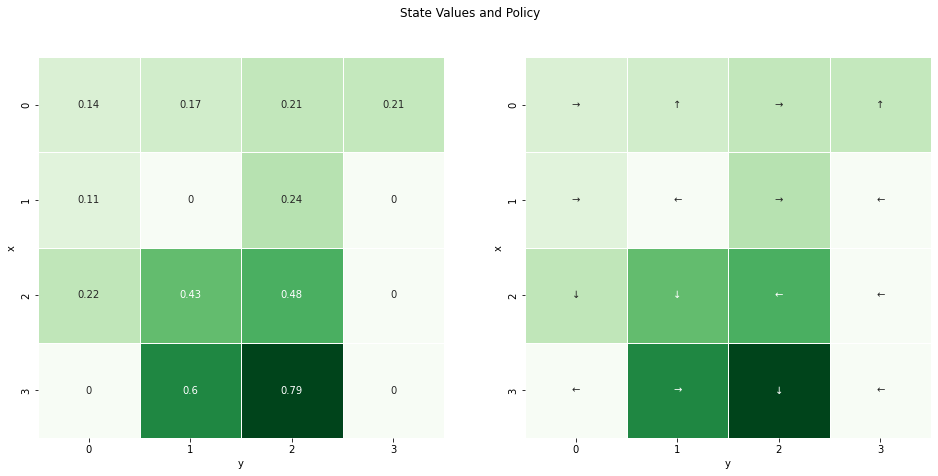

In [14]:
# Reshape Data
returns = new_policy.pivot("x", "y", "return")
direction = new_policy.pivot("x", "y", "label")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16,7))
fig.suptitle('State Values and Policy',)

sns.heatmap(new_policy.pivot("x", "y", "return"), annot=True, linewidths=.5, cbar=False, cmap="Greens", ax=axes[0]);
sns.heatmap(new_policy.pivot("x", "y", "return"), annot=np.array(direction), linewidths=.5, cbar=False, cmap="Greens", fmt = '', ax=axes[1]);